In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
path = Path('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/')

In [7]:
print(path)

gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai


In [8]:
path.ls()

[PosixPath('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/pneumonia'),
 PosixPath('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/normal'),
 PosixPath('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/train'),
 PosixPath('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/validation'),
 PosixPath('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/test'),
 PosixPath('gdrive/My Drive/Proyectos/2020/covid19/covid/covid2/dataset_fastai/models')]

torch.Size([3, 362, 445])


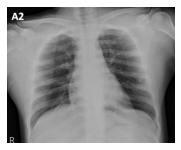

In [9]:
img = open_image(path/'train/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png')
print(img.data.shape)
img.show()

In [0]:
np.random.seed(7)
tfms = get_transforms(do_flip=True,flip_vert=False, max_rotate=25)

In [11]:
help(ImageDataBunch.from_folder)

Help on method from_folder in module fastai.vision.data:

from_folder(path:Union[pathlib.Path, str], train:Union[pathlib.Path, str]='train', valid:Union[pathlib.Path, str]='valid', test:Union[pathlib.Path, str, NoneType]=None, valid_pct=None, seed:int=None, classes:Collection=None, **kwargs:Any) -> 'ImageDataBunch' method of builtins.type instance
    Create from imagenet style dataset in `path` with `train`,`valid`,`test` subfolders (or provide `valid_pct`).



In [0]:
data = ImageDataBunch.from_folder(path, train="train", valid='validation', test='test', ds_tfms=tfms, size=224, bs=bs,
                                  num_workers=4).normalize(imagenet_stats)

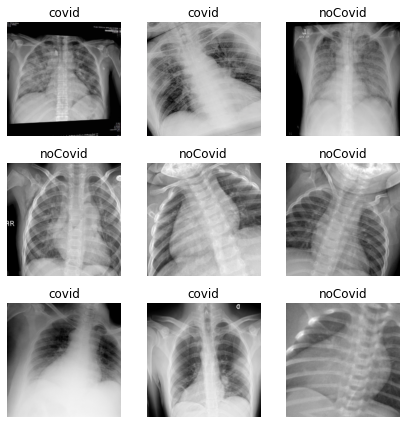

In [13]:
data.show_batch(3, figsize=(6,6))

In [14]:
data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds), len(data.classes)

(2, 153, 79, 83, 2)

MODELO

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.904857,0.156853,0.088608,00:37
1,0.822787,0.415600,0.088608,00:14
2,0.732370,0.363564,0.075949,00:15
3,0.673001,0.343724,0.101266,00:15


In [17]:
dest=Path(base_dir + "models/covidnocovid/")
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

File Already Exists


In [0]:
learn.save(dest/'covidnocovid_stage-1-resnet34-augmented_tvt')

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

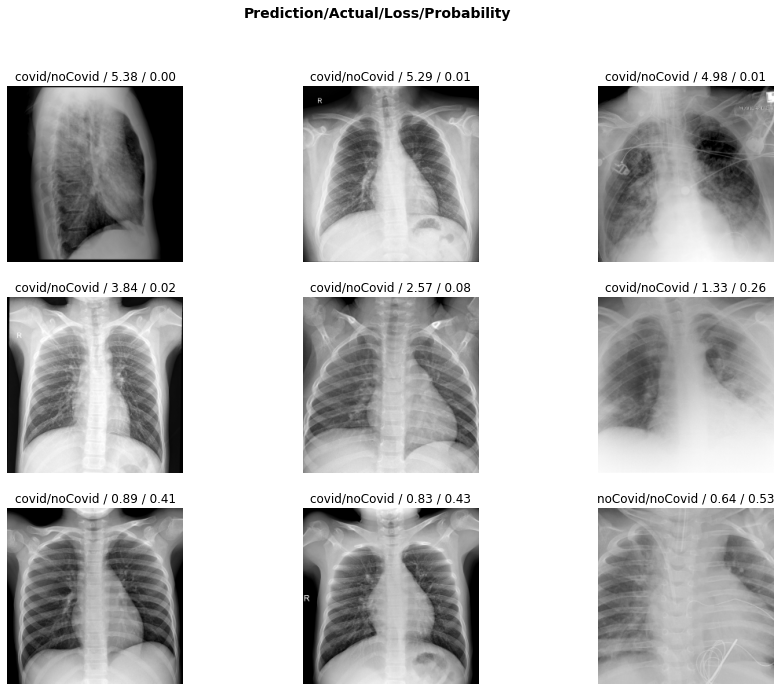

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

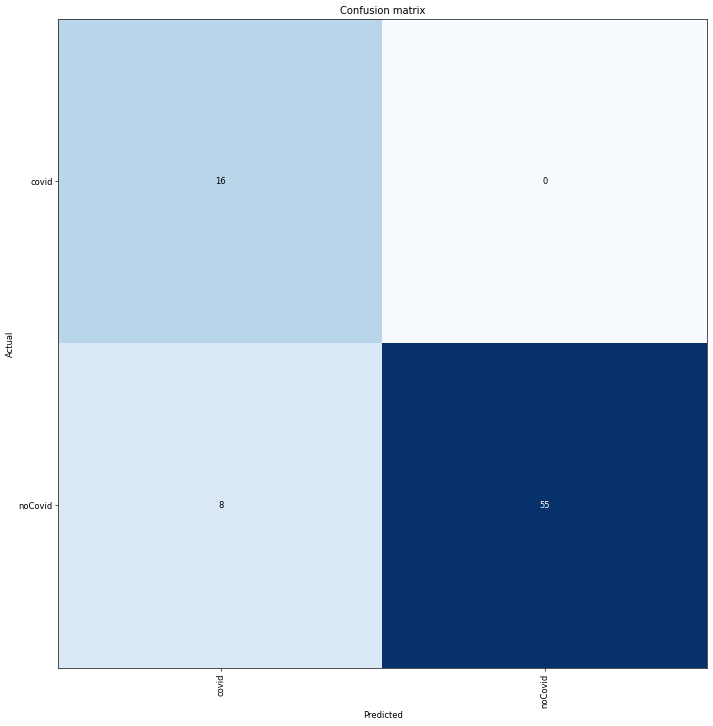

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('noCovid', 'covid', 8)]

Unfreezing, fine-tuning and learning rates

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


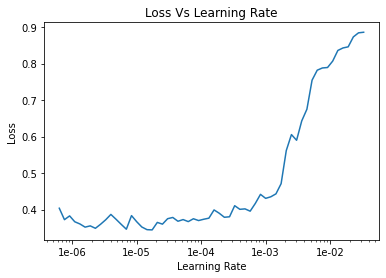

In [24]:
learn.lr_find()
learn.recorder.plot()
plt.title("Loss Vs Learning Rate")
plt.show()

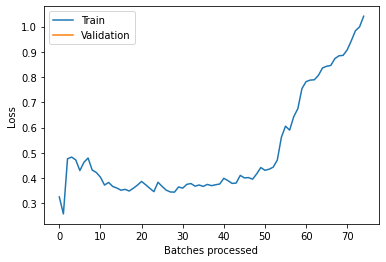

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4)) #3e-5, 3e-4

epoch,train_loss,valid_loss,error_rate,time
0,0.532741,0.228859,0.101266,00:15
1,0.527744,0.105716,0.050633,00:14
2,0.524087,0.083379,0.012658,00:15
3,0.477249,0.106305,0.037975,00:15
4,0.436119,0.120663,0.050633,00:15
5,0.424274,0.121169,0.037975,00:14
6,0.389943,0.126507,0.037975,00:15
7,0.370014,0.114652,0.037975,00:15
8,0.355434,0.132603,0.037975,00:15
9,0.362683,0.122098,0.037975,00:14


In [0]:
learn.save(dest/'covidnocovid_stage-2-resnet34-augmented_tvt')

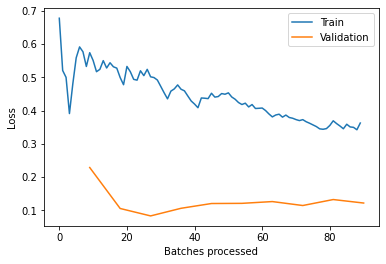

In [28]:
learn.recorder.plot_losses()

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

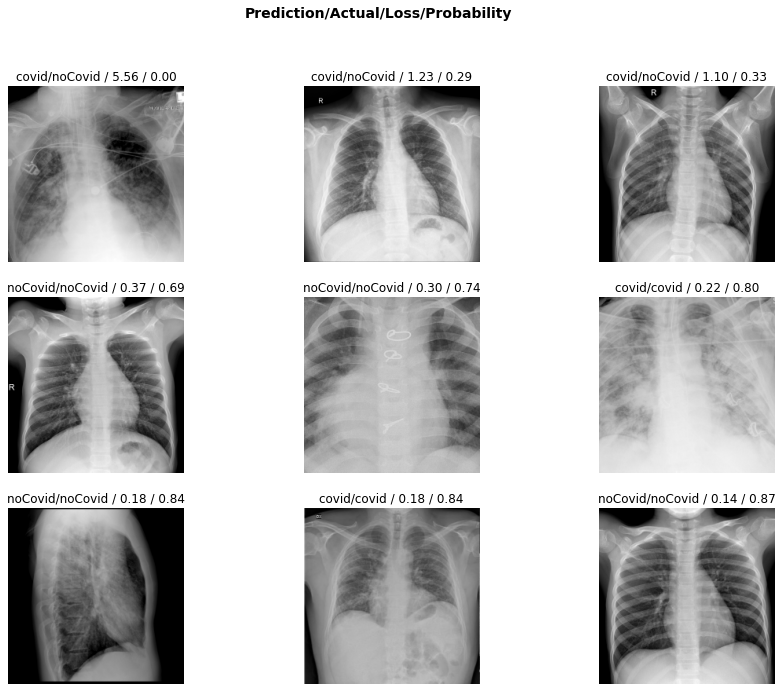

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

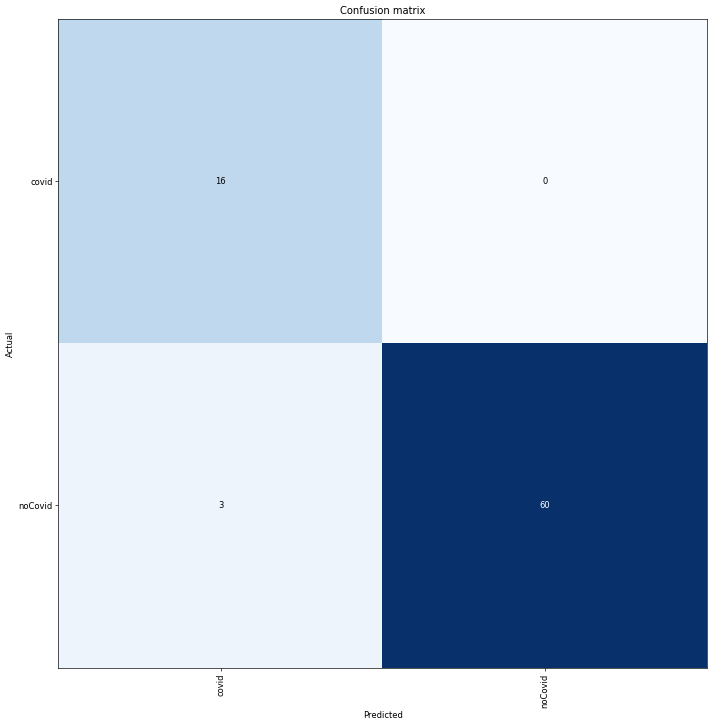

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
interp.most_confused(min_val=2)

[('noCovid', 'covid', 3)]

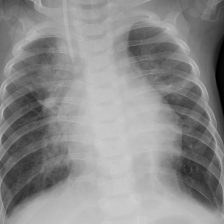

In [56]:
img = learn.data.test_ds[54][0]
img

In [57]:
learn.predict(img)

(Category noCovid, tensor(1), tensor([1.9421e-05, 9.9998e-01]))